## Prepare chirps data for Pacific Islands

## libraries

In [1]:
import xcast as xc
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

#functions, constants, created in same folder
#import xcast_season_config as cfg
import helper_functions as helper
#automatically reloads the configuration file once updated and saved
%load_ext autoreload
%autoreload 2

In [7]:
season_dict= {
    'JFM': [1,2,3],
    'FMA': [2,3,4],
    'MAM': [3,4,5],
    'AMJ': [4,5,6],
    'MJJ': [5,6,7],
    'JJA': [6,7,8],
    'JAS': [7,8,9],
    'ASO': [8,9,10],
    'SON': [9,10,11],
    'OND': [10,11,12],
    'NDJ': [11,12,1],
    'DJF': [12,1,2]
}

month_number_dict = {
    1: 'J',
    2: 'F',
    3: 'M',
    4: 'A',
    5: 'M',
    6: 'J',
    7: 'J',
    8: 'A',
    9: 'S',
    10:'O',
    11:'N',
    12:'D'}

In [8]:
raw_chirps_dir = '/cpc/int_desk/data/chirps'
trial = xr.open_dataset(os.path.join(raw_chirps_dir, 'chirps-v2.0.2024.days_p05.nc'))
trial

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, time: 121)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2024-01-01 2024-01-02 ... 2024-04-30
Data variables:
    precip     (time, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2024-05-15
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day....
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [9]:
ds = xr.open_mfdataset(os.path.join(raw_chirps_dir,
                                            'chirps-v2.0.*days_p05.nc'), 
                               combine = "by_coords", 
                               engine = "netcdf4", 
                               chunks={'time': 121, 'latitude': 2000, 'longitude': 720})
monthly = ds.resample(time='1M').mean()
monthly_first =  prepped_predictor_obs = helper.change_dates_to_first(monthly, 'time')
years = helper.getYears(1981,2023)

In [10]:
months = [1,2,3,4,5,6,7,8,9,10,11,12]

seasons = []
for m in months:
    if m == 11:
        season = []
        for y in np.unique(monthly.time.dt.year):
            seas_1 = monthly.sel(time = monthly.time.dt.month.isin([11,12]))
            seas_1 = seas_1.sel(time = seas_1.time.dt.year.isin(y))
            seas_2 = monthly.sel(time = monthly.time.dt.month.isin([1]))
            seas_2 = seas_2.sel(time = seas_2.time.dt.year.isin(y+1))
            season_year =  xr.concat([seas_1, seas_2], dim = 'time').mean(dim = 'time')
            season_year = season_year.expand_dims({'year':int(y)})
            season.append(season_year)
        season = xr.concat(season, dim = 'year')
        season = season.expand_dims({'season':['NDJ']})
    elif m == 12:
        season = []
        for y in np.unique(monthly.time.dt.year):
            seas_1 = monthly.sel(time = monthly.time.dt.month.isin([12]))
            seas_1 = seas_1.sel(time = seas_1.time.dt.year.isin(y))
            seas_2 = monthly.sel(time = monthly.time.dt.month.isin([1,2]))
            seas_2 = seas_2.sel(time = seas_2.time.dt.year.isin(y+1))
            season_year =  xr.concat([seas_1, seas_2], dim = 'time').mean(dim = 'time')
            season_year = season_year.expand_dims({'year':int(y)})
            season.append(season_year)
        season = xr.concat(season, dim = 'year')
        season = season.expand_dims({'season':['DJF']})
    else:
        seas_months = monthly.sel(time = monthly.time.dt.month.isin([m, m+1, m+2]))
        season = seas_months.groupby('time.year').mean()
        season = season.expand_dims({'season':[month_number_dict[m] + month_number_dict[m+1] + month_number_dict[m+2]]})
    season = season.sel(year = season.year.isin(years))
    seasons.append(season)
seasons = xr.concat(seasons, dim = 'season')
seasons

<xarray.Dataset>
Dimensions:    (latitude: 2000, longitude: 7200, year: 43, season: 12)
Coordinates:
  * latitude   (latitude) float32 -49.97 -49.92 -49.88 ... 49.87 49.92 49.97
  * longitude  (longitude) float32 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2020 2021 2022 2023
  * season     (season) object 'JFM' 'FMA' 'MAM' 'AMJ' ... 'OND' 'NDJ' 'DJF'
Data variables:
    precip     (season, year, latitude, longitude) float32 dask.array<chunksize=(1, 1, 2000, 720), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

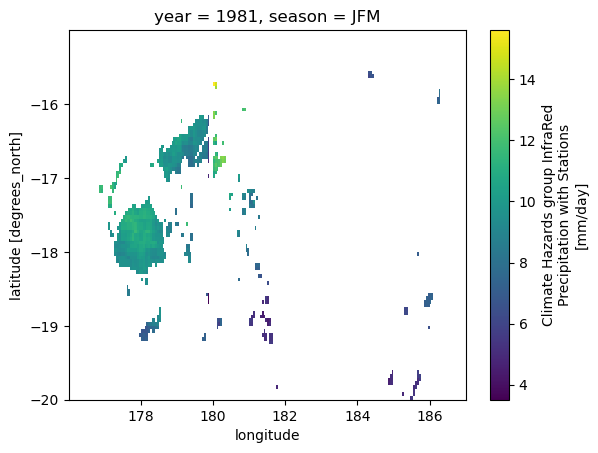

In [11]:
#large predictor zone
large_w=170
large_e=250
large_s=-25
large_n=0

#update coordinates to 0-360 grid
chirps_360 = helper.adjust_longitude_to_360(seasons, 'longitude').sortby('latitude', ascending = False).sortby('longitude', ascending = True)
chirps_pacisl = chirps_360.sortby('longitude', ascending=True).sel(longitude = slice(large_w, large_e),
                              latitude = slice(large_n, large_s))
chirps_pacisl.isel(season=0,year=0).precip.sel(longitude = slice(176, 187),
                              latitude = slice(-15, -20)).plot()

In [13]:
chirps_pacisl.isel(season=0)

<xarray.Dataset>
Dimensions:    (latitude: 500, longitude: 1600, year: 43)
Coordinates:
  * latitude   (latitude) float32 -0.025 -0.075 -0.125 ... -24.88 -24.92 -24.98
  * longitude  (longitude) float32 170.0 170.1 170.1 170.2 ... 249.9 249.9 250.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2020 2021 2022 2023
    season     <U3 'JFM'
Data variables:
    precip     (year, latitude, longitude) float32 dask.array<chunksize=(1, 500, 200), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

In [21]:
for s in np.unique(chirps_pacisl.season):
    print(s)
    print(chirps_pacisl.sel(season=s))

AMJ
<xarray.Dataset>
Dimensions:    (latitude: 500, longitude: 1600, year: 43)
Coordinates:
  * latitude   (latitude) float32 -0.025 -0.075 -0.125 ... -24.88 -24.92 -24.98
  * longitude  (longitude) float32 170.0 170.1 170.1 170.2 ... 249.9 249.9 250.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2020 2021 2022 2023
    season     <U3 'AMJ'
Data variables:
    precip     (year, latitude, longitude) float32 dask.array<chunksize=(1, 500, 200), meta=np.ndarray>
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    

NameError: name 'chirps_pac' is not defined

In [2]:
season_test = xr.open_dataset('/cpc/int_desk/pac_isl/data/processed/chirps/nc_files/chirps05_pac-islands')

In [3]:
season_test
#season_plot = season_test.precip.isel(year=5).plot(col = 'season', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})

<xarray.Dataset>
Dimensions:    (latitude: 500, longitude: 1600, year: 43, season: 12)
Coordinates:
  * latitude   (latitude) float32 -0.025 -0.075 -0.125 ... -24.88 -24.92 -24.98
  * longitude  (longitude) float32 170.0 170.1 170.1 170.2 ... 249.9 249.9 250.0
  * year       (year) int64 1981 1982 1983 1984 1985 ... 2020 2021 2022 2023
  * season     (season) object 'JFM' 'FMA' 'MAM' 'AMJ' ... 'OND' 'NDJ' 'DJF'
Data variables:
    precip     (season, year, latitude, longitude) float32 ...
Attributes: (12/15)
    Conventions:       CF-1.6
    title:             CHIRPS Version 2.0
    history:           created by Climate Hazards Group
    version:           Version 2.0
    date_created:      2015-11-20
    creator_name:      Pete Peterson
    ...                ...
    reference:         Funk, C.C., Peterson, P.J., Landsfeld, M.F., Pedreros,...
    comments:           time variable denotes the first day of the given day.
    acknowledgements:  The Climate Hazards Group InfraRed Precipitation with ...
    ftp_url:           ftp://chg-ftpout.geog.ucsb.edu/pub/org/chg/products/CH...
    website:           http://chg.geog.ucsb.edu/data/chirps/index.html
    faq:               http://chg-wiki.geog.ucsb.edu/wiki/CHIRPS_FAQ

<xarray.DataArray 'precip' (latitude: 100, longitude: 140)>
[14000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -15.03 -15.08 -15.12 ... -19.88 -19.93 -19.98
  * longitude  (longitude) float32 176.0 176.1 176.1 176.2 ... 182.9 182.9 183.0
    year       int64 2023
    season     <U3 'JJA'
Attributes:
    units:               mm/day
    standard_name:       convective precipitation rate
    long_name:           Climate Hazards group InfraRed Precipitation with St...
    time_step:           day
    geostatial_lat_min:  -50.0
    geostatial_lat_max:  50.0
    geostatial_lon_min:  -180.0
    geostatial_lon_max:  180.0
<xarray.DataArray 'precip' (latitude: 100, longitude: 140)>
[14000 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 -15.03 -15.08 -15.12 ... -19.88 -19.93 -19.98
  * longitude  (longitude) float32 176.0 176.1 176.1 176.2 ... 182.9 182.9 183.0
    year       int64 2023
    season     <U3 'JAS'
Attributes:
    units:       

/cpc/home/kkowal/.conda/envs/xcast_env/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/cpc/home/kkowal/.conda/envs/xcast_env/lib/python3.9/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


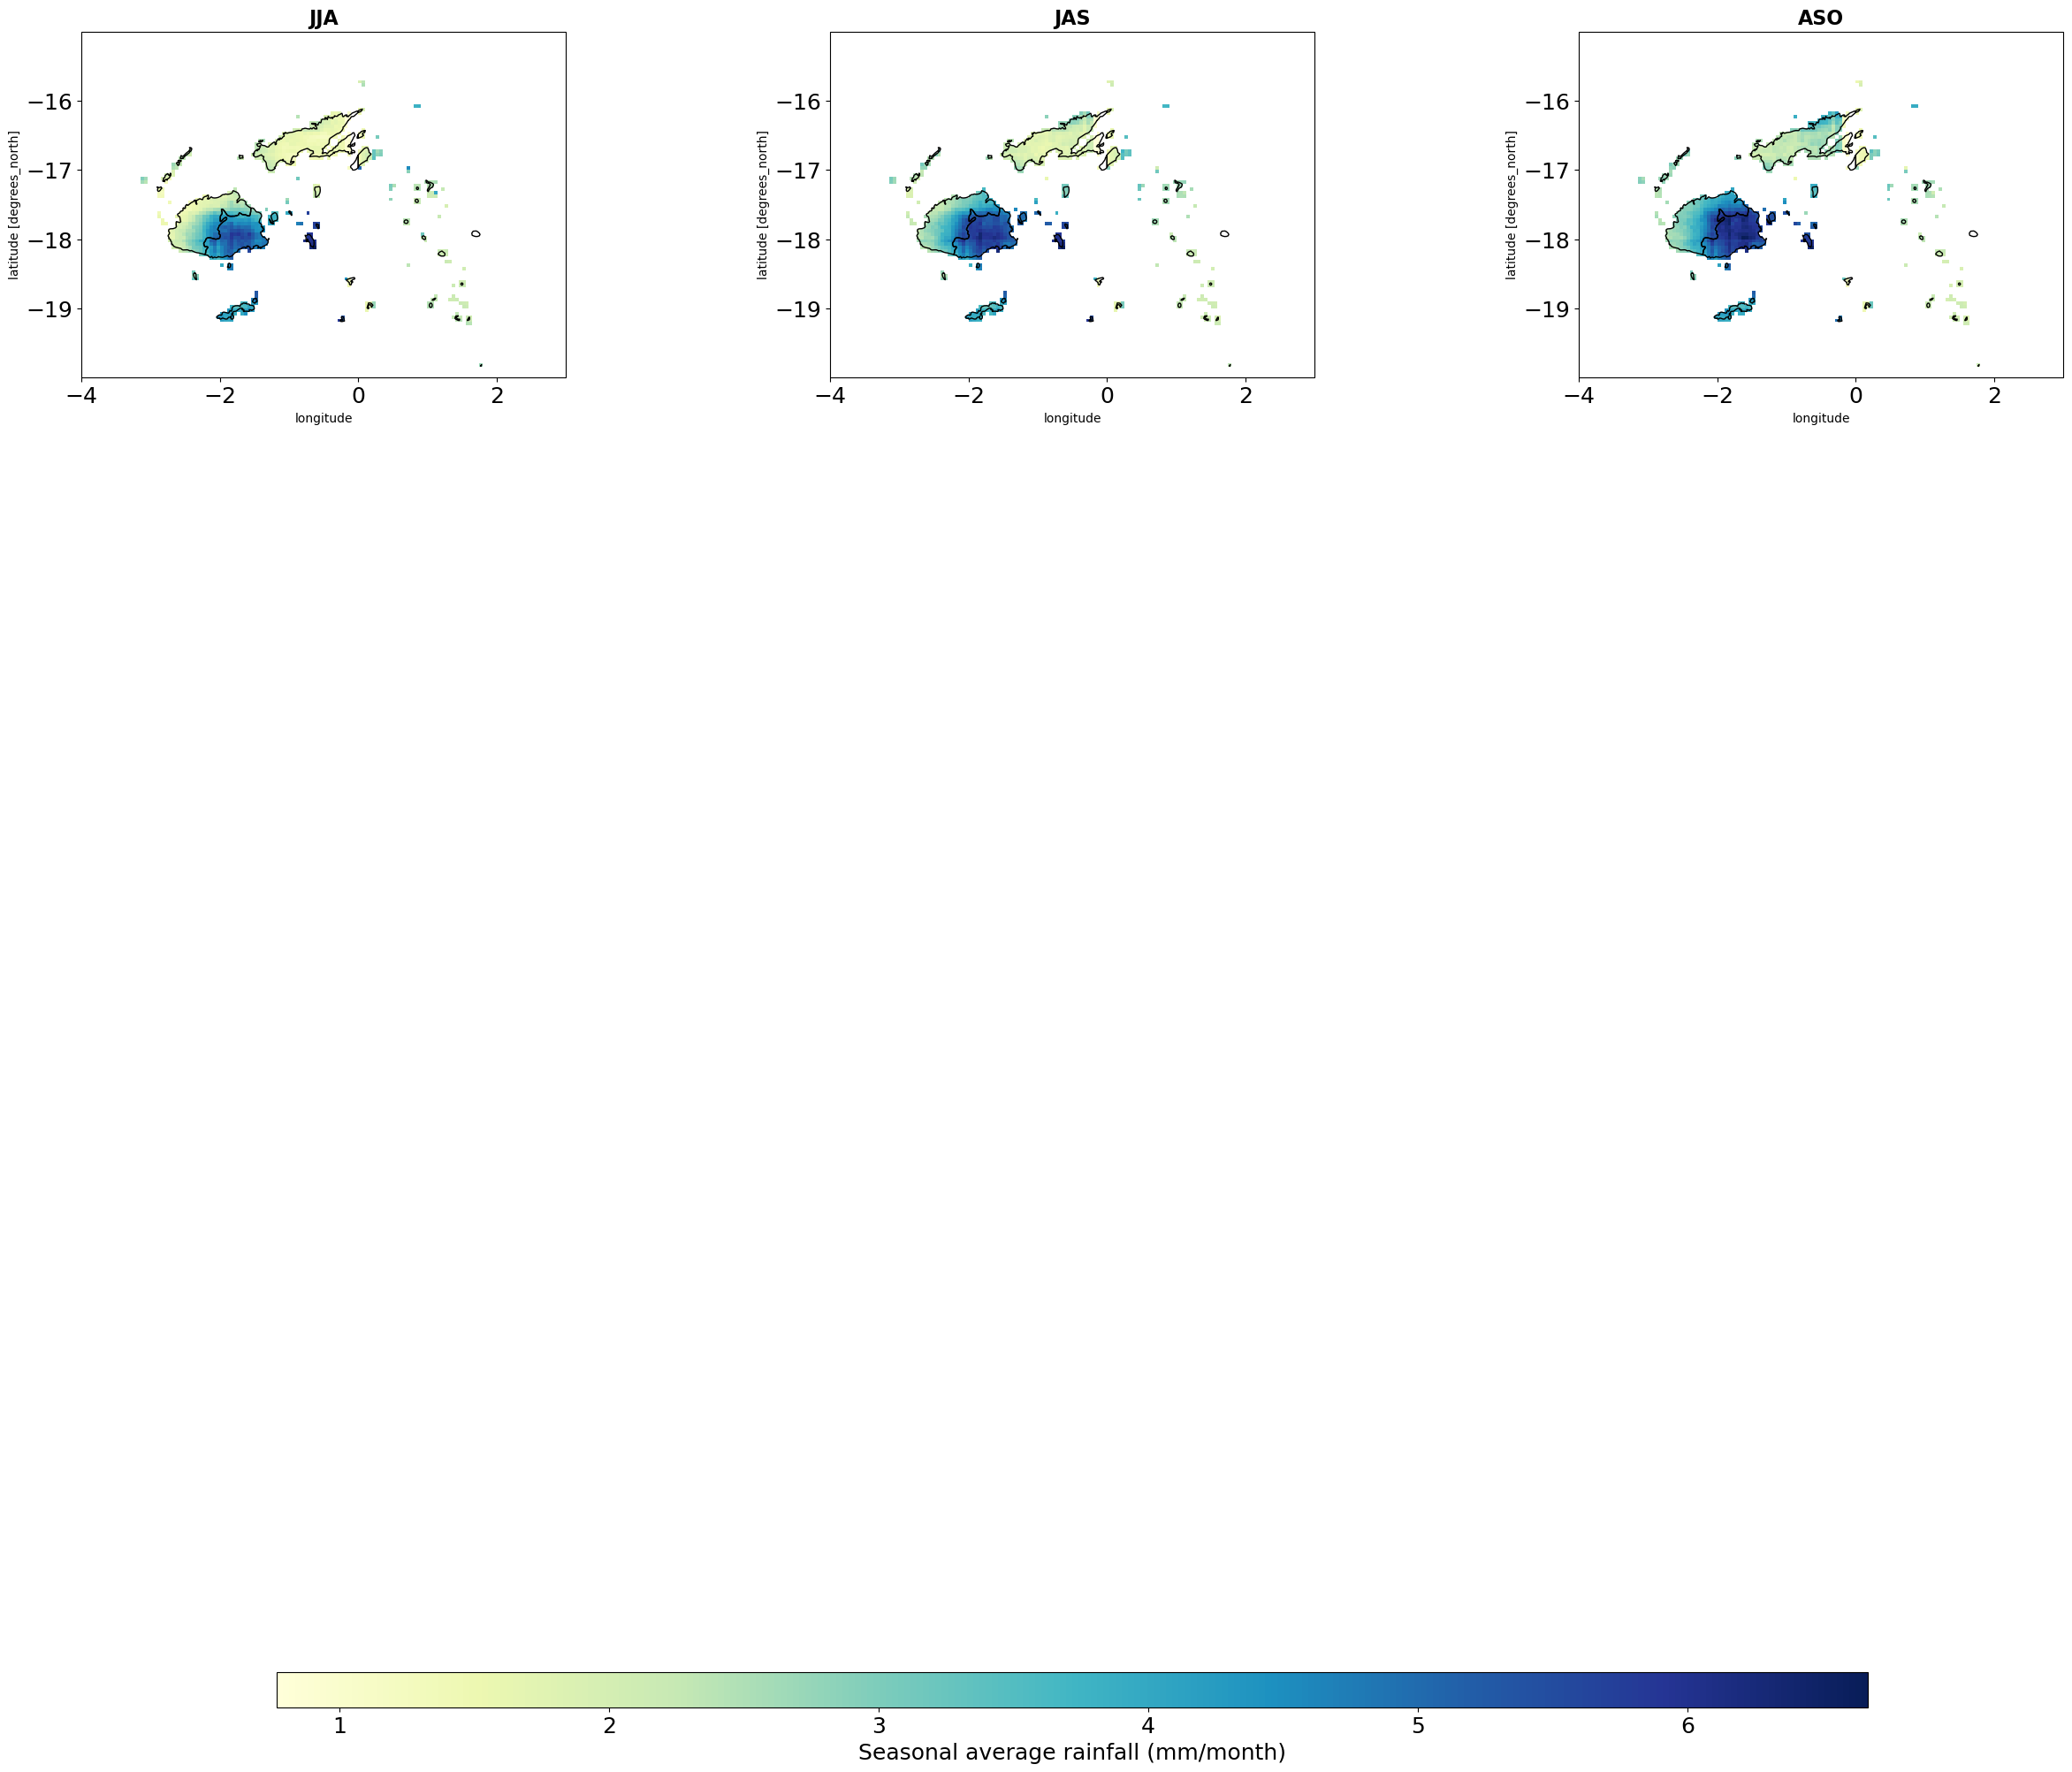

In [11]:
#import calendar
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each season and plot the data
for i, s in enumerate(['JJA', 'JAS', 'ASO']):#'JFM', 'FMA']):#, 'MAM', 'AMJ', , 'ASO', 'SON', 'OND', 'NDJ', 'DJF']):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(4, 3, i+1, projection=ccrs.PlateCarree(central_longitude=180))
    P =season_test.precip.sel(season = s, year = 2023).sel(longitude = slice(176, 183),
                              latitude = slice(-15, -20))
    print(P)
    # Plot data for the current month
    im =P.plot(ax=ax,transform=ccrs.PlateCarree(),cmap='YlGnBu',add_colorbar=False)#  vmin=0, vmax=600, levels=21, 
    del P
    #Set title with month name
    ax.set_title(s, fontsize=16, weight='bold')
    
    # Add features
    ax.add_feature(cf.BORDERS)
    ax.add_feature(cf.STATES)
    # Set the ticks manually
    #xticks = [176, 178, 180, 182]
    #yticks = [-19,  -18,  -17, -16]
    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    # Set the tick labels
    #ax.set_xticklabels(['176°E', '178°E', '180°', '182°E'])
    #ax.set_yticklabels(['19°S', '18°S', '17°S', '16°S'])
    # Set font size for tick labels
    plt.setp(ax.get_xticklabels(), fontsize=18)
    plt.setp(ax.get_yticklabels(), fontsize=18)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.2, hspace=0.2)
# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Seasonal average rainfall (mm/month)', fontsize=18)
cbar.ax.tick_params(labelsize=18)

# Show plot
plt.show()

In [14]:
xr.open_dataset('/cpc/int_desk/pac_isl/data/processed/nmme/nc_files/nmme_hind_precip_ld1.nc')

<xarray.Dataset>
Dimensions:  (lat: 181, lon: 360, time: 32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * time     (time) datetime64[ns] 2024-05-31 2025-05-31 ... 2055-05-31
Data variables:
    precip   (time, lat, lon) float64 ...